In [1]:
import anndata as ad
import numpy as np
import scipy
import pandas as pd
import torch
import scanpy as sc
import matplotlib.pyplot as plt

### PCA embedding for 41201 cells

In [2]:
# read h5ad file

adata_subset = ad.read_h5ad('Larry_41201_2000.h5ad')
print("adata_subset.X.shape:", adata_subset.X.shape)
print("number of lineages: ", len(adata_subset.obs['clone_id'].unique()))

adata_subset.X.shape: (41201, 2000)
number of lineages:  2817


#### get the PCA embeddings

In [3]:
# question!!!
# sc.pp.log1p(adata_subset)

In [4]:
sc.pp.scale(adata_subset, max_value=10)
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=40)


#### run leiden clustering on PCA embeddings

In [5]:
# adjust the resolution to change the number of leiden clusters
sc.tl.leiden(adata_subset, resolution=0.7)
cluster_labels = adata_subset.obs['leiden']
print("number of clusters: ", len(cluster_labels.unique()))

number of clusters:  15


#### create a dataframe for the number of unqiue clusters the number of cells in each lineage

In [6]:
lineage_stats = adata_subset.obs.groupby('clone_id').agg({
    'leiden': ["nunique", "count"]
})

# renaming the columns
lineage_stats.columns = ['num_leiden_PCA', 'total_cells']

print(lineage_stats)

          num_leiden_PCA  total_cells
clone_id                             
0                      1            5
1                      2           20
2                      3           20
4                      1            9
5                      2            6
...                  ...          ...
5845                   2           24
5848                   2           12
5850                   5           11
5857                   3           14
5858                   2            7

[2817 rows x 2 columns]


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


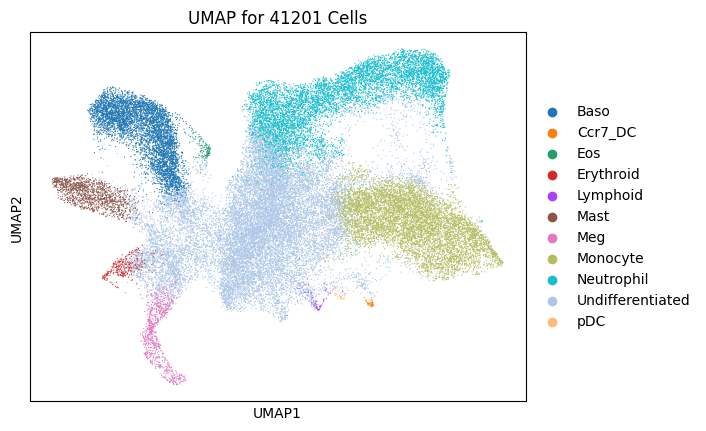

In [29]:
sc.tl.umap(adata_subset)
sc.pl.umap(adata_subset,color='Cell type annotation', title="UMAP for 41201 Cells")
# sc.tl.umap(adata_subset)
# sc.pl.umap(adata_subset, color=['leiden'])

### Contrastive Learning embedding for 41201 cells

In [8]:
Feat_Z = np.load('out/scBaseEncoderFeat_Z.npy')
adata_Z = sc.AnnData(Feat_Z)
print("shape of the CL embedding: ", Feat_Z.shape)

shape of the CL embedding:  (41201, 64)


#### run leiden clustering on CL embeddings

In [9]:
sc.pp.neighbors(adata_Z, n_neighbors=10, use_rep='X')

# Perform Leiden clustering
sc.tl.leiden(adata_Z, resolution=0.26)

clusters = adata_Z.obs['leiden']
print("number of clusters: ",len(clusters.unique()))

number of clusters:  15


In [10]:
obs_df = adata_subset.obs.loc[:, ['clone_id',"leiden"]]
obs_df['leiden'] = clusters.to_numpy()
obs_df

,clone_id,leiden
0,573,7
1,1440,6
2,394,1
4,1972,9
6,1450,3
...,...,...
130874,4999,7
130875,12,9
130876,267,7
130877,3534,7


In [11]:
unique_clusters_per_clone = obs_df.groupby('clone_id')['leiden'].nunique()
lineage_stats["num_leiden_CL"] = unique_clusters_per_clone.to_numpy()
lineage_stats

,num_leiden_PCA,total_cells,num_leiden_CL
clone_id,,,
0,1,5,2
1,2,20,3
2,3,20,3
4,1,9,2
5,2,6,3
...,...,...,...
5845,2,24,2
5848,2,12,3
5850,5,11,5


In [28]:
adata_subset.obs.groupby("leiden").size()

/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_20885/828635570.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_subset.obs.groupby("leiden").size()


leiden
0     4826
1     4783
2     4654
3     4630
4     3916
5     3854
6     3792
7     2631
8     2348
9     1511
10    1482
11    1191
12     846
13     535
14     202
dtype: int64

In [27]:
adata_Z_df = adata_Z.obs
adata_Z_df.groupby("leiden").size()

/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_20885/2329418419.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_Z_df.groupby("leiden").size()


leiden
0     5525
1     4785
2     3750
3     3645
4     3571
5     3543
6     3371
7     2580
8     2169
9     2076
10    1627
11    1607
12    1492
13    1436
14      24
dtype: int64

#### Scatter plot of CL embedding vs PCA embedding

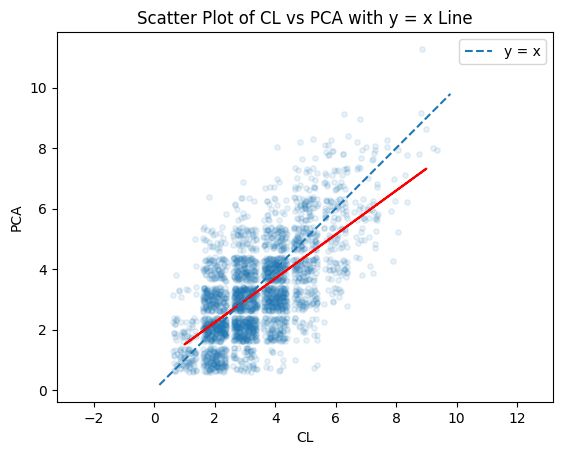

In [23]:
import numpy as np
plt.scatter(lineage_stats["num_leiden_CL"]+np.random.uniform(low = -0.4, high = 0.4, size = 2817),
            lineage_stats["num_leiden_PCA"]+np.random.uniform(low = -0.4, high = 0.4, size = 2817), 
            alpha=0.1, s=15)  # Adjust 's' for size as needed



# Compute the coefficients of the linear regression line
m, b = np.polyfit(lineage_stats["num_leiden_CL"], lineage_stats["num_leiden_PCA"], 1)

# Generate y-values for the regression line based on the coefficients
y_regression = m * lineage_stats["num_leiden_CL"] + b

# Create the scatter plot
# plt.scatter(lineage_stats["num_leiden_CL"], lineage_stats["num_leiden_PCA"])

# Add the regression line to the plot
plt.plot(lineage_stats["num_leiden_CL"], y_regression, color='red', label='SLR') # You can change the color if you like





# Add y = x line
x = np.linspace(*plt.xlim(), 100)  
plt.plot(x, x, '--', label='y = x') 

plt.title('Scatter Plot of CL vs PCA with y = x Line')  
plt.xlabel('CL') 
plt.ylabel('PCA')  
plt.axis('equal')
plt.legend()  

plt.savefig('CL_PCA.png', dpi=300)
plt.show()  


In [14]:
lineage_stats["num_leiden_CL"].corr(lineage_stats["num_leiden_PCA"])

0.6567273566220605

In [15]:
lineage_stats["num_leiden_CL"].size

2817